In [3]:
!pip install awswrangler

Keyring is skipped due to an exception: 'keyring.backends'


In [4]:
!pip install fastparquet

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached fastparquet-0.8.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
  Using cached cramjam-2.6.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)


In [2]:
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import awswrangler as wr
import os, sys
role = get_execution_role()
s3 = boto3.resource('s3')

LOAD DATA

In [3]:
icusics_db_patients = wr.s3.read_parquet(path="s3://icusics-db/patients/patients.parquet")
var = wr.s3.read_parquet(path="s3://icusics-db/d_variables/d_variables.parquet")

numeric =[]
labs=[]

for h in icusics_db_patients.hospital_coded.unique():
    labs.append(wr.s3.read_parquet(path="s3://icusics-db/labresults_numeric/labresults_numeric_h%s.parquet"%h))
    numeric.append(wr.s3.read_parquet(path="s3://icusics-db/observed_numeric/observed_numeric_h%s.parquet"%h))

labs= pd.concat(labs)
numeric= pd.concat(numeric)

extract diuresis and creatinine codes 

In [4]:
idx= np.where(var.name.str.contains("diur|urine|diür|outp|urin|cathe|orin", case=False))[0]
idx_diuresis = var.iloc[idx]
idx_diuresis.name.value_counts()

SOFA Renal: S-Crea  o diüresi     32
Aspecte diüresi                   26
Diüresi Objectiu                  14
Característiques Orina            13
Eliminació urinària espontània    10
                                  ..
Buidatge de bossa de diuresi       1
Eliminació urinària espontànea     1
URINOCULTIU/                       1
Glucosa Orina Quant                1
Orina 12 h                         1
Name: name, Length: 209, dtype: Int64

In [5]:
id_diuresis= [1010010000,2010010000,3010010000,4010010000,5010010000,6010010000]

In [7]:
idx= np.where(var.name.str.contains("scr|creatinine|creat", case=False))[0]
idx_scr = var.iloc[idx]
# a_variableid: 2020000600 - links to : labresults_numeric
idx_scr.name.value_counts()

Prescripció: tipus dieta oral     38
Prescripció: Modo ventilació      29
SOFA Renal: Creat o Diuresis       8
Prescripció: Posició malalt        8
Prescrip: Tipus oxigenoteràpia     8
                                  ..
Prescripció: Ramsay c/ h           1
Prescripció: Gliucosúria c/ h      1
Atrium Sens.Prescripció mèdica     1
Prescripció: Glicèmia c/ h         1
Creatinina orina 24 hores          1
Name: name, Length: 80, dtype: Int64

In [8]:
id_scr= [1020000600,2020000600,3020000600,4020000600,5020000600,6020000600]

EXTRACT SCR AND UO DATA FROM ALL HOSPITALS

In [9]:
labs= labs[labs.a_variableid.isin(id_scr)]
numeric= numeric[numeric.a_variableid.isin(id_diuresis)]

In [10]:
labs.describe()

,a_patientid,a_variableid,time,value
count,1.266920e+05,1.266920e+05,1.266920e+05,126692.000000
mean,3.541334e+06,3.064968e+09,1.486528e+04,1.780393
std,1.538956e+06,1.512984e+09,2.225432e+04,12.355123
min,1.000091e+06,1.020001e+09,-1.093188e+06,0.000000
25%,2.358474e+06,2.020001e+09,1.507000e+03,0.540000
50%,3.273498e+06,3.020001e+09,6.436000e+03,0.790000
75%,4.531265e+06,4.020001e+09,1.972225e+04,1.360000
max,6.999255e+06,6.020001e+09,4.381570e+05,860.000000


In [16]:
labs['hospital_code']= labs.apply(lambda x: str(x.a_variableid)[0], axis=1)
labs['hospital_code'].value_counts()

2    39081
3    25808
4    23607
1    17545
6    14959
5     5692
Name: hospital_code, dtype: int64

In [56]:
labs['gap'] = labs.time - labs.groupby("a_patientid").time.shift()

Distribution of serum creatinine values in different hospitals

<Figure size 640x480 with 0 Axes>

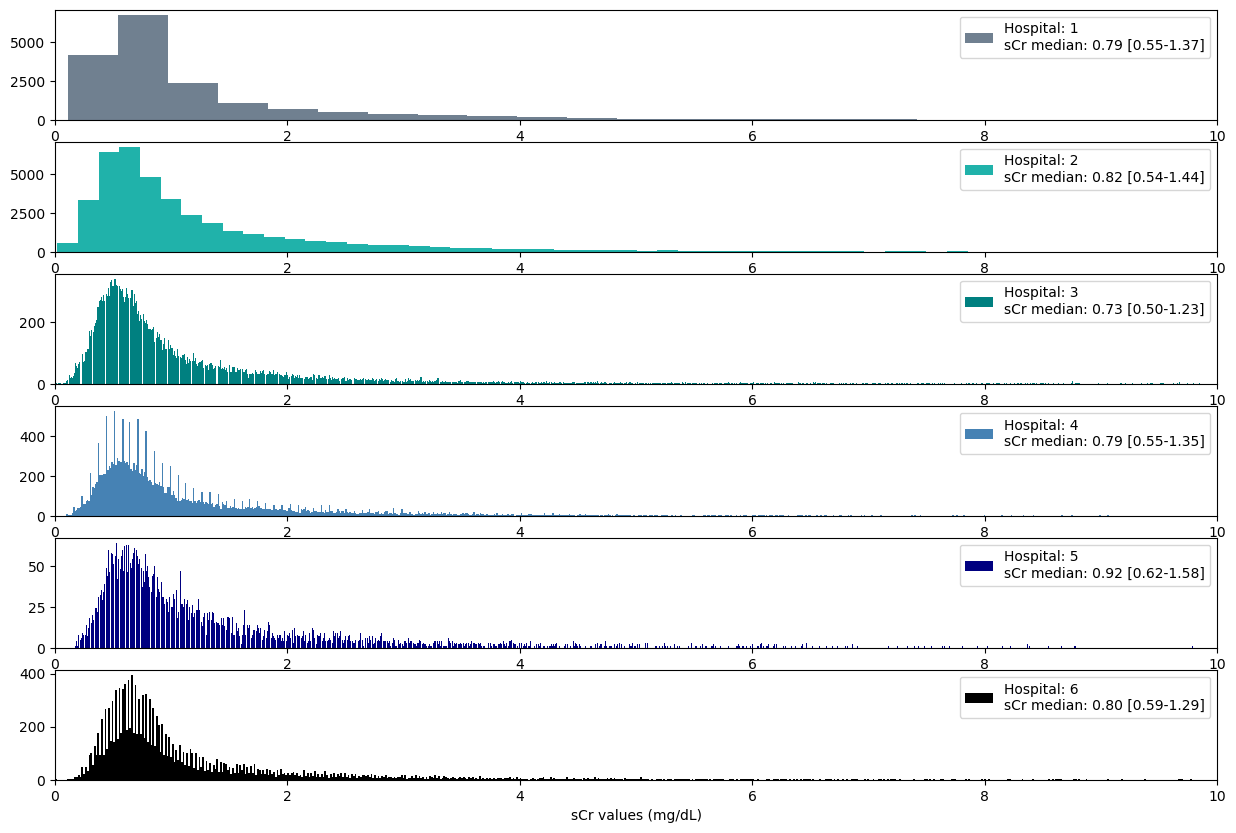

In [98]:
import matplotlib.pyplot as plt 
plt.figure(figsize= (15,10))
bins = 2000
c = ['slategray','lightseagreen','teal','steelblue','navy','k']
for h in np.arange(1,7,1):
    htmp=labs[labs.hospital_code == str(h)]
    if h == 1:
        plt.title('Distribution of serum creatinine values in different hospitals')
    plt.subplot(6,1,h)
    plt.hist(htmp.value, bins= bins, color= c[h-1],  label='Hospital: %s \nsCr median: %.2f [%.2f-%.2f]'%(h, htmp.value.median(), np.percentile(htmp.value.dropna(), 25), np.percentile(htmp.value.dropna(), 75)))
    plt.xlabel('sCr values (mg/dL)')
    plt.xlim(0,10)
    plt.legend()
    
plt.show()

In [99]:
#plt.savefig("scr_median_values_all_hospitals.png")

Distribution of acquisition frequency of serum creatinine in different hospitals

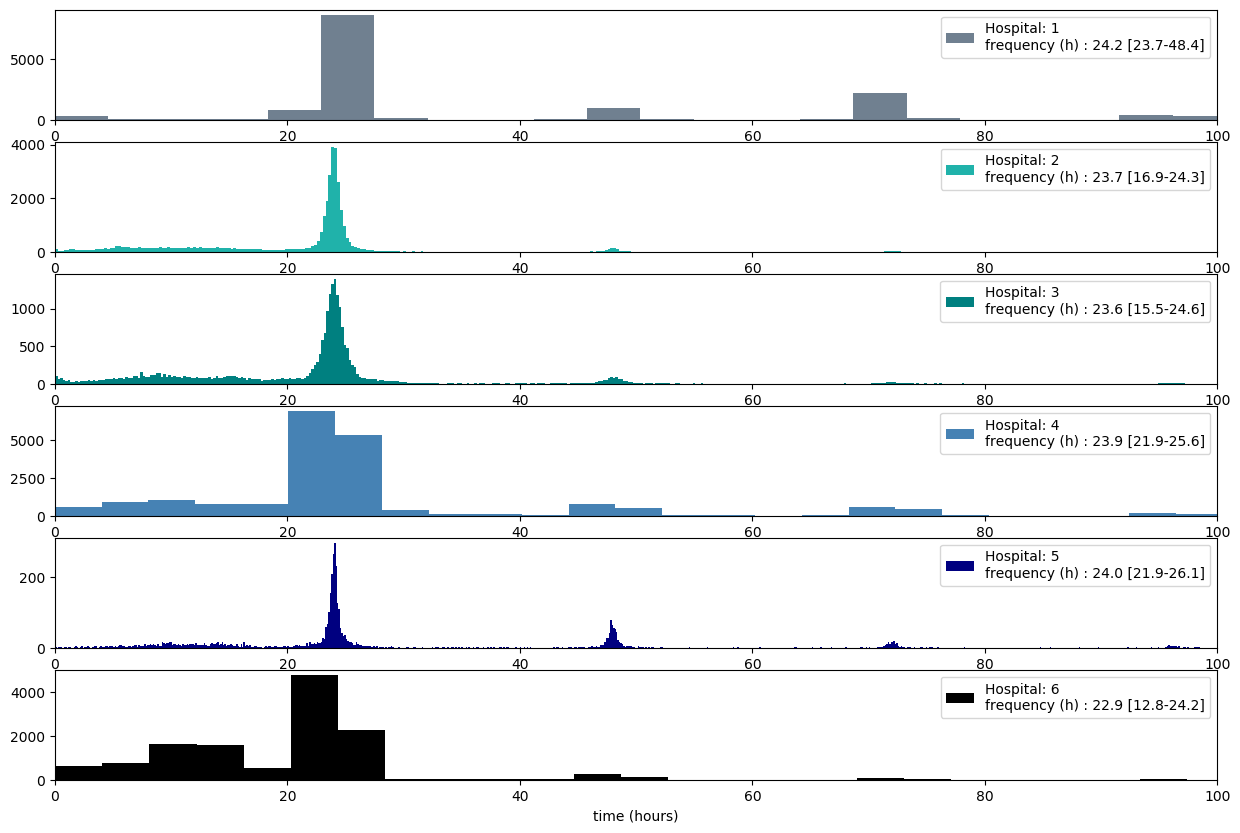

In [73]:
import matplotlib.pyplot as plt 
plt.figure(figsize= (15,10))
bins = 2000
c = ['slategray','lightseagreen','teal','steelblue','navy','k']
for h in np.arange(1,7,1):
    htmp=labs[labs.hospital_code == str(h)]
    if h == 1:
        plt.title('Distribution of acquisition frequency of serum creatinine in different hospitals')
        bins= 4000
    plt.subplot(6,1,h)
    plt.hist(htmp.gap.dropna()/60, bins= bins, color= c[h-1],  label='Hospital: %s \nfrequency (h) : %.1f [%.1f-%.1f]'%(h, htmp.gap.median()/60, np.percentile(htmp.gap.dropna()/60, 25), np.percentile(htmp.gap.dropna()/60, 75)))
    plt.xlim(0,100)
    plt.xlabel('time (hours)')
    plt.legend()
plt.show()

In [93]:
#plt.savefig("scr_acq_frequency_all_hospitals.png")

In [11]:
numeric.describe()

,a_patientid,a_variableid,time,value
count,1.772967e+06,1.772967e+06,1.772967e+06,1.772967e+06
mean,3.184491e+06,2.699314e+09,1.717728e+04,4.302846e+02
std,1.486005e+06,1.457739e+09,2.275016e+04,3.531428e+05
min,1.000091e+06,1.010010e+09,-5.267910e+05,-1.000000e+03
25%,2.076933e+06,2.010010e+09,2.483000e+03,6.000000e+01
50%,2.803086e+06,2.010010e+09,8.463000e+03,1.200000e+02
75%,4.237849e+06,4.010010e+09,2.334800e+04,2.200000e+02
max,6.999255e+06,6.010010e+09,4.428080e+05,4.702189e+08


In [74]:
numeric['gap'] = numeric.time - numeric.groupby("a_patientid").time.shift()

Distribution of diuresis in different hospitals

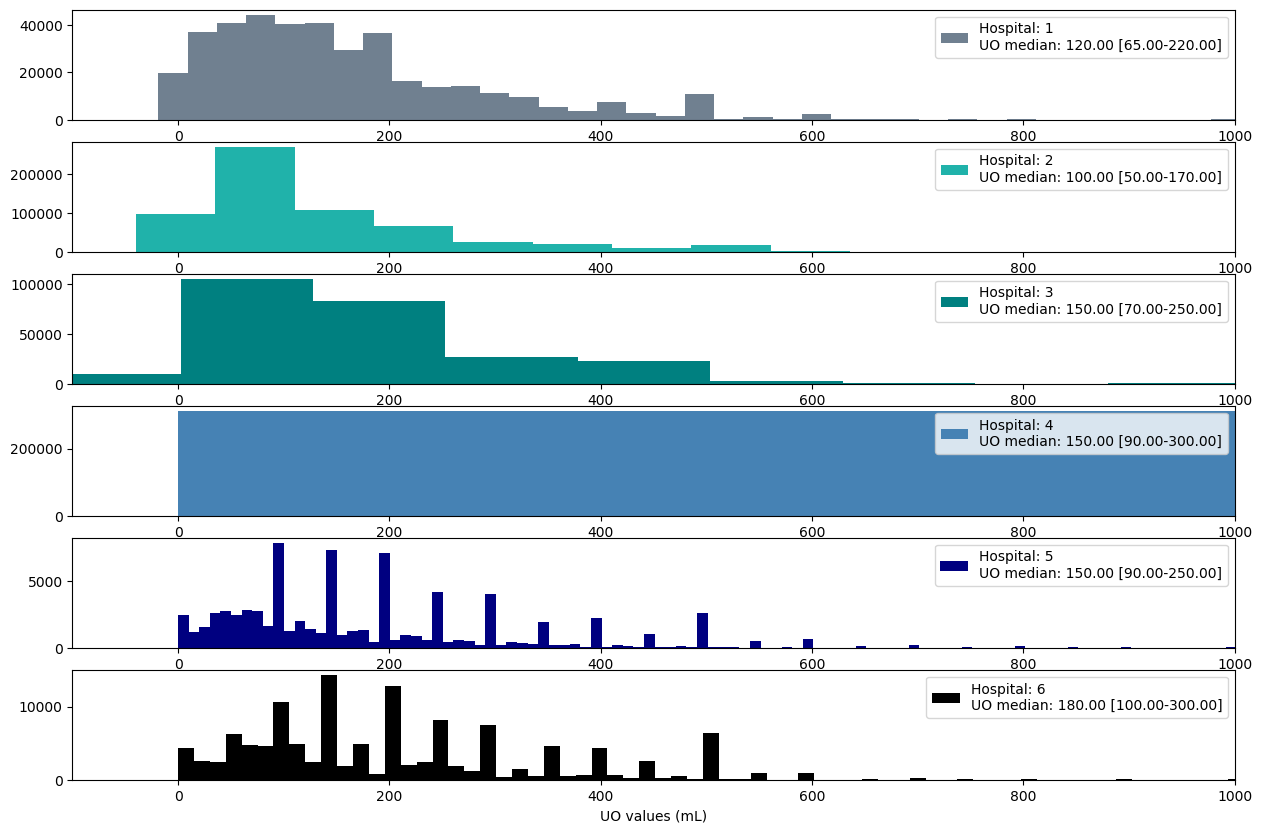

In [91]:
import matplotlib.pyplot as plt 
plt.figure(figsize= (15,10))
bins = 4000
counter=0
c = ['slategray','lightseagreen','teal','steelblue','navy','k']
for h in numeric.a_variableid.unique():
    counter +=1
    htmp=numeric[numeric.a_variableid == h]
    if counter == 4:
        bins = 10000
    plt.subplot(6,1,counter)
    plt.hist(htmp.value, bins= bins, color= c[counter-1],  label='Hospital: %s \nUO median: %.2f [%.2f-%.2f]'%(counter, htmp.value.median(), np.percentile(htmp.value.dropna(), 25), np.percentile(htmp.value.dropna(), 75)))
    plt.xlabel('UO values (mL)')
    plt.xlim(-100,1000)
    plt.legend()
    
plt.show()

In [95]:
#plt.savefig("uo_median_values_all_hospitals.png")

Distribution of acquisition frequency of diuresis in different hospitals

<Figure size 640x480 with 0 Axes>

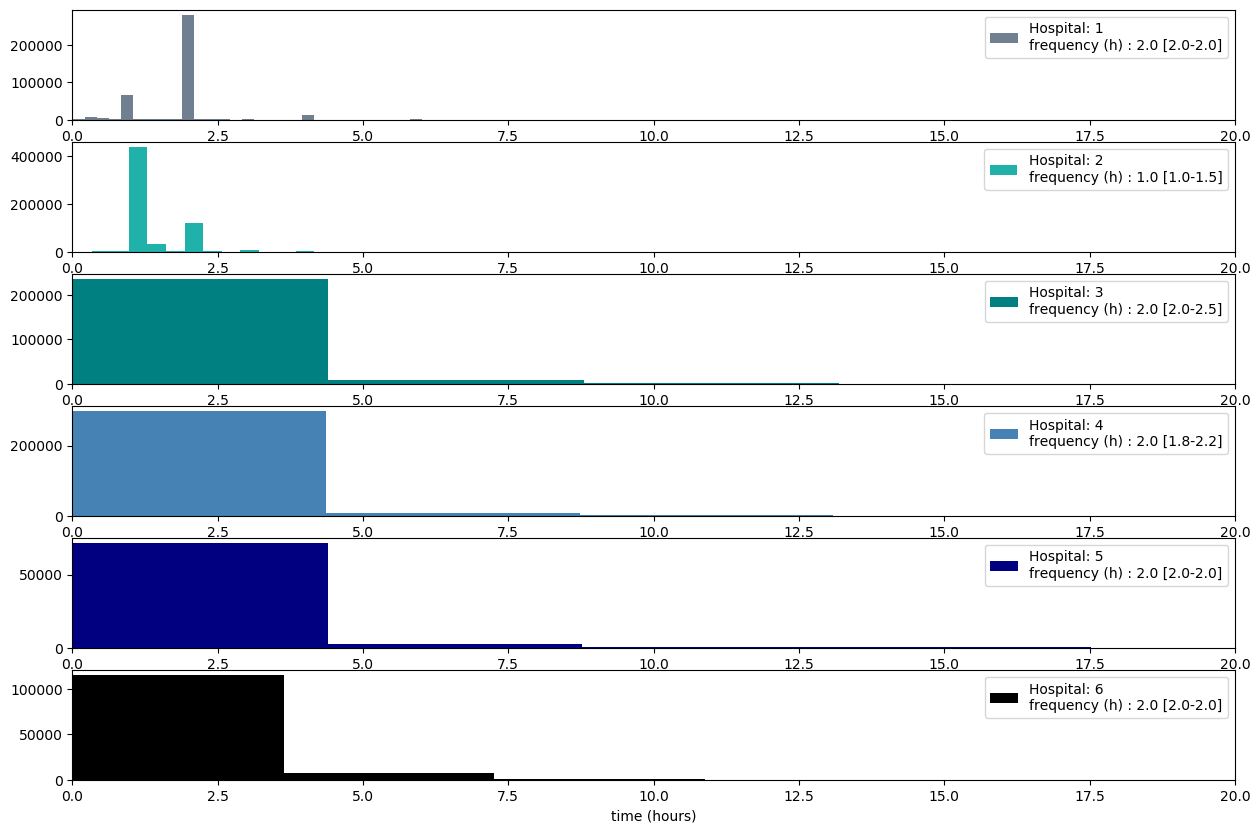

In [96]:
import matplotlib.pyplot as plt 
plt.figure(figsize= (15,10))
bins = 2000
c = ['slategray','lightseagreen','teal','steelblue','navy','k']
counter =0

for h in numeric.a_variableid.unique():
    counter +=1
    htmp=numeric[numeric.a_variableid == h]
    plt.subplot(6,1,counter)
    plt.hist(htmp.gap.dropna()/60, bins= bins, color= c[counter-1],  label='Hospital: %s \nfrequency (h) : %.1f [%.1f-%.1f]'%(counter, htmp.gap.median()/60, np.percentile(htmp.gap.dropna()/60, 25), np.percentile(htmp.gap.dropna()/60, 75)))
    plt.xlim(0,20)
    plt.xlabel('time (hours)')
    plt.legend()
plt.show()

In [97]:
#plt.savefig("uo_acq_frequency_all_hospitals.png")

In [100]:
labs.to_csv("scr_all_hosp.csv", index=False)

In [101]:
numeric.to_csv("uo_all_hosp.csv", index=False)